# GoEmotions - Model Training Pipeline

**Task**: Multi-label Emotion Classification  
**Models**: BERT-base, DistilBERT, TinyBERT  
**Loss**: Binary Cross-Entropy (BCE)  

---

## Pipeline Overview

1. Environment Setup
2. Load Processed Data
3. Multi-label Model Configuration
4. Custom Training Infrastructure
5. Fine-tune BERT-base
6. Fine-tune DistilBERT
7. Fine-tune TinyBERT
8. Save Models & Results

## 1. Environment Setup

In [13]:
!pip install -q transformers datasets accelerate evaluate scikit-learn
!pip install -q matplotlib seaborn pandas numpy

In [14]:
import torch

if torch.cuda.is_available():
    print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    device = torch.device('cuda')
else:
    print("⚠️ No GPU available, using CPU")
    device = torch.device('cpu')

print(f"\nUsing device: {device}")

✅ GPU Available: Tesla T4
   Memory: 15.8 GB

Using device: cuda


In [15]:
import os
import json
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    hamming_loss,
    jaccard_score
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

print("✅ All imports successful!")

✅ All imports successful!


## 2. Load Processed Data

In [16]:
class TrainingConfig:
    DATA_DIR = './processed_data'
    MODEL_DIR = './models'
    LOG_DIR = './logs'
    
    MODEL_CHECKPOINTS = {
        'bert-base': 'bert-base-uncased',
        'distilbert': 'distilbert-base-uncased',
        'tinybert': 'huawei-noah/TinyBERT_General_4L_312D'
    }
    
    BATCH_SIZE = 16
    GRADIENT_ACCUMULATION_STEPS = 2
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 4
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01
    
    THRESHOLD = 0.5
    PROBLEM_TYPE = 'multi_label_classification'
    
    EVAL_STRATEGY = 'epoch'
    SAVE_STRATEGY = 'epoch'
    METRIC_FOR_BEST_MODEL = 'f1_micro'
    EARLY_STOPPING_PATIENCE = 2
    
    FP16 = torch.cuda.is_available()
    
    NUM_LABELS = 28
    
    SEED = 42

config = TrainingConfig()

os.makedirs(config.MODEL_DIR, exist_ok=True)
os.makedirs(config.LOG_DIR, exist_ok=True)

torch.manual_seed(config.SEED)
np.random.seed(config.SEED)

print("📋 Training Configuration:")
print(f"   Problem Type: {config.PROBLEM_TYPE}")
print(f"   Batch Size: {config.BATCH_SIZE}")
print(f"   Effective Batch Size: {config.BATCH_SIZE * config.GRADIENT_ACCUMULATION_STEPS}")
print(f"   Epochs: {config.NUM_EPOCHS}")
print(f"   Threshold: {config.THRESHOLD}")

📋 Training Configuration:
   Problem Type: multi_label_classification
   Batch Size: 16
   Effective Batch Size: 32
   Epochs: 4
   Threshold: 0.5


In [17]:
print("📥 Loading processed dataset...")

dataset_path = os.path.join(config.DATA_DIR, 'go_emotions_tokenized')
dataset = load_from_disk(dataset_path)

print(f"\n✅ Dataset loaded!")
print(dataset)

config_path = os.path.join(config.DATA_DIR, 'go_emotions_config.json')
with open(config_path, 'r') as f:
    data_config = json.load(f)

LABEL_NAMES = data_config['label_names']
config.NUM_LABELS = data_config['num_labels']

print(f"\n📋 Data Configuration:")
print(f"   Number of labels: {config.NUM_LABELS}")
print(f"   Train: {data_config['train_size']:,}")
print(f"   Validation: {data_config['val_size']:,}")
print(f"   Test: {data_config['test_size']:,}")

📥 Loading processed dataset...

✅ Dataset loaded!
DatasetDict({
    train: Dataset({
        features: ['labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5427
    })
})

📋 Data Configuration:
   Number of labels: 28
   Train: 43,410
   Validation: 5,426
   Test: 5,427


## 3. Multi-label Model Configuration

In [18]:
def compute_multilabel_metrics(eval_pred, threshold=0.5):
    """
    Compute comprehensive multi-label classification metrics.
    
    Args:
        eval_pred: tuple of (predictions, labels)
        threshold: classification threshold for sigmoid outputs
    
    Returns:
        dict: computed metrics
    """
    logits, labels = eval_pred
    
    probs = 1 / (1 + np.exp(-logits))
    predictions = (probs > threshold).astype(int)
    labels = labels.astype(int)
    
    metrics = {
        'f1_micro': f1_score(labels, predictions, average='micro', zero_division=0),
        'f1_macro': f1_score(labels, predictions, average='macro', zero_division=0),
        'f1_weighted': f1_score(labels, predictions, average='weighted', zero_division=0),
        'f1_samples': f1_score(labels, predictions, average='samples', zero_division=0),
        
        'precision_micro': precision_score(labels, predictions, average='micro', zero_division=0),
        'recall_micro': recall_score(labels, predictions, average='micro', zero_division=0),
        
        'hamming_loss': hamming_loss(labels, predictions),
        
        'exact_match': accuracy_score(labels, predictions),
        
        'jaccard_micro': jaccard_score(labels, predictions, average='micro', zero_division=0),
    }
    
    return metrics

print("✅ Multi-label metrics configured!")

✅ Multi-label metrics configured!


In [19]:
def get_model_info(model):
    """Get model parameter count and size."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / 1024 / 1024
    
    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'size_mb': size_mb
    }

def print_model_info(model, model_name):
    """Print formatted model information."""
    info = get_model_info(model)
    print(f"\n📊 {model_name} Model Information:")
    print(f"   Total Parameters: {info['total_params']:,}")
    print(f"   Trainable Parameters: {info['trainable_params']:,}")
    print(f"   Model Size: {info['size_mb']:.1f} MB")
    return info

## 4. Training Infrastructure

In [20]:
class MultiLabelTrainer(Trainer):
    """
    Custom Trainer for multi-label classification.
    Handles BCE loss and class weighting for imbalanced data.
    """
    
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop('labels').float()
        outputs = model(**inputs)
        logits = outputs.logits
        
        if self.class_weights is not None:
            weights = self.class_weights.to(logits.device)
            loss_fct = nn.BCEWithLogitsLoss(pos_weight=weights)
        else:
            loss_fct = nn.BCEWithLogitsLoss()
        
        loss = loss_fct(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

print("✅ MultiLabelTrainer configured!")

✅ MultiLabelTrainer configured!


In [21]:
def compute_class_weights(dataset, num_labels):
    """
    Compute class weights for handling imbalanced data.
    Uses inverse frequency weighting.
    """
    label_counts = np.zeros(num_labels)
    
    for sample in dataset:
        labels = np.array(sample['labels'])
        label_counts += labels
    
    total_samples = len(dataset)
    
    pos_weight = (total_samples - label_counts) / (label_counts + 1e-6)
    
    pos_weight = np.clip(pos_weight, 1.0, 10.0)
    
    return torch.tensor(pos_weight, dtype=torch.float32)

print("⚖️ Computing class weights...")
class_weights = compute_class_weights(dataset['train'], config.NUM_LABELS)

print(f"\nClass weights computed!")
print(f"   Min weight: {class_weights.min():.2f}")
print(f"   Max weight: {class_weights.max():.2f}")
print(f"   Mean weight: {class_weights.mean():.2f}")

⚖️ Computing class weights...

Class weights computed!
   Min weight: 2.05
   Max weight: 10.00
   Mean weight: 9.70


In [22]:
def create_multilabel_trainer(model, tokenizer, model_name, train_dataset, eval_dataset, class_weights=None):
    """
    Create trainer for multi-label classification.
    """
    output_dir = os.path.join(config.MODEL_DIR, model_name)
    logging_dir = os.path.join(config.LOG_DIR, model_name)
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        
        num_train_epochs=config.NUM_EPOCHS,
        per_device_train_batch_size=config.BATCH_SIZE,
        per_device_eval_batch_size=config.BATCH_SIZE * 2,
        gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,
        
        learning_rate=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY,
        warmup_ratio=config.WARMUP_RATIO,
        
        eval_strategy=config.EVAL_STRATEGY,
        save_strategy=config.SAVE_STRATEGY,
        load_best_model_at_end=True,
        metric_for_best_model=config.METRIC_FOR_BEST_MODEL,
        greater_is_better=True,
        save_total_limit=2,
        
        logging_dir=logging_dir,
        logging_strategy='steps',
        logging_steps=100,
        report_to='none',
        
        fp16=config.FP16,
        dataloader_num_workers=2,
        
        seed=config.SEED,
    )
    
    trainer = MultiLabelTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_multilabel_metrics,
        class_weights=class_weights,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=config.EARLY_STOPPING_PATIENCE)]
    )
    
    return trainer

print("✅ Training infrastructure ready!")

✅ Training infrastructure ready!


In [23]:
def train_and_evaluate_multilabel(model_key, model_checkpoint):
    """
    Complete training pipeline for multi-label classification.
    """
    print(f"\n{'='*60}")
    print(f"🚀 Training {model_key.upper()} for Multi-label Classification")
    print(f"   Checkpoint: {model_checkpoint}")
    print(f"{'='*60}")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    print(f"\n📦 Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    
    print(f"📦 Loading model...")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_checkpoint,
        num_labels=config.NUM_LABELS,
        problem_type=config.PROBLEM_TYPE,
        id2label={i: label for i, label in enumerate(LABEL_NAMES)},
        label2id={label: i for i, label in enumerate(LABEL_NAMES)}
    )
    
    model_info = print_model_info(model, model_key)
    
    print(f"\n⚙️ Creating trainer...")
    trainer = create_multilabel_trainer(
        model=model,
        tokenizer=tokenizer,
        model_name=f"go_emotions_{model_key}",
        train_dataset=dataset['train'],
        eval_dataset=dataset['validation'],
        class_weights=class_weights
    )
    
    print(f"\n🏋️ Starting training...")
    start_time = time.time()
    
    train_result = trainer.train()
    
    training_time = time.time() - start_time
    print(f"\n✅ Training complete! Time: {training_time/60:.1f} minutes")
    
    print(f"\n📊 Evaluating on validation set...")
    val_metrics = trainer.evaluate()
    
    print(f"\n📊 Evaluating on test set...")
    test_metrics = trainer.evaluate(dataset['test'])
    
    save_path = os.path.join(config.MODEL_DIR, f"go_emotions_{model_key}_best")
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"\n💾 Model saved to: {save_path}")
    
    results = {
        'model_key': model_key,
        'model_checkpoint': model_checkpoint,
        'model_info': model_info,
        'training_time_minutes': training_time / 60,
        'train_metrics': train_result.metrics,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics
    }
    
    print(f"\n📋 {model_key.upper()} Results Summary:")
    print(f"   Val F1 (Micro): {val_metrics['eval_f1_micro']:.4f}")
    print(f"   Test F1 (Micro): {test_metrics['eval_f1_micro']:.4f}")
    print(f"   Test F1 (Macro): {test_metrics['eval_f1_macro']:.4f}")
    print(f"   Test Hamming Loss: {test_metrics['eval_hamming_loss']:.4f}")
    
    del model, trainer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return results

## 5. Fine-tune BERT-base

In [24]:
bert_results = train_and_evaluate_multilabel(
    model_key='bert-base',
    model_checkpoint=config.MODEL_CHECKPOINTS['bert-base']
)


🚀 Training BERT-BASE for Multi-label Classification
   Checkpoint: bert-base-uncased

📦 Loading tokenizer...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📦 Loading model...

📊 bert-base Model Information:
   Total Parameters: 109,503,772
   Trainable Parameters: 109,503,772
   Model Size: 417.7 MB

⚙️ Creating trainer...

🏋️ Starting training...


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,F1 Samples,Precision Micro,Recall Micro,Hamming Loss,Exact Match,Jaccard Micro,Runtime,Samples Per Second,Steps Per Second
1,0.376600,0.350783,0.506916,0.410297,0.532034,0.543123,0.384447,0.743887,0.060772,0.198120,0.339509,5.026400,1079.493000,33.821000
2,0.304900,0.311739,0.520920,0.450959,0.555018,0.561803,0.396768,0.758150,0.058561,0.227976,0.352192,4.985600,1088.343000,34.098000
3,0.255400,0.305412,0.528501,0.471815,0.557954,0.566991,0.409789,0.744044,0.055750,0.247512,0.359159,5.201000,1043.259000,32.686000
4,0.239300,0.306332,0.538318,0.471878,0.564992,0.577418,0.421463,0.744828,0.053650,0.266495,0.368286,5.252400,1033.055000,32.366000



✅ Training complete! Time: 14.2 minutes

📊 Evaluating on validation set...



📊 Evaluating on test set...

💾 Model saved to: ./models/go_emotions_bert-base_best

📋 BERT-BASE Results Summary:
   Val F1 (Micro): 0.5383
   Test F1 (Micro): 0.5316
   Test F1 (Macro): 0.4759
   Test Hamming Loss: 0.0544


## 6. Fine-tune DistilBERT

In [25]:
distilbert_results = train_and_evaluate_multilabel(
    model_key='distilbert',
    model_checkpoint=config.MODEL_CHECKPOINTS['distilbert']
)


🚀 Training DISTILBERT for Multi-label Classification
   Checkpoint: distilbert-base-uncased

📦 Loading tokenizer...
📦 Loading model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 distilbert Model Information:
   Total Parameters: 66,975,004
   Trainable Parameters: 66,975,004
   Model Size: 255.5 MB

⚙️ Creating trainer...

🏋️ Starting training...


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,F1 Samples,Precision Micro,Recall Micro,Hamming Loss,Exact Match,Jaccard Micro,Runtime,Samples Per Second,Steps Per Second
1,0.362600,0.335089,0.506634,0.417529,0.537794,0.541526,0.391356,0.718182,0.058738,0.216181,0.339257,2.774900,1955.388000,61.264000
2,0.304300,0.305434,0.519111,0.460103,0.556698,0.555621,0.397403,0.748276,0.058218,0.214891,0.350540,3.108600,1745.462000,54.686000
3,0.255700,0.302359,0.527490,0.474320,0.560460,0.564836,0.407123,0.748903,0.056342,0.235164,0.358225,3.026800,1792.647000,56.165000
4,0.245800,0.304289,0.538401,0.483398,0.566716,0.575926,0.420816,0.747179,0.053802,0.258017,0.368364,3.141900,1727.002000,54.108000



✅ Training complete! Time: 7.7 minutes

📊 Evaluating on validation set...



📊 Evaluating on test set...

💾 Model saved to: ./models/go_emotions_distilbert_best

📋 DISTILBERT Results Summary:
   Val F1 (Micro): 0.5384
   Test F1 (Micro): 0.5311
   Test F1 (Macro): 0.4699
   Test Hamming Loss: 0.0547


## 7. Fine-tune TinyBERT

In [26]:
tinybert_results = train_and_evaluate_multilabel(
    model_key='tinybert',
    model_checkpoint=config.MODEL_CHECKPOINTS['tinybert']
)


🚀 Training TINYBERT for Multi-label Classification
   Checkpoint: huawei-noah/TinyBERT_General_4L_312D

📦 Loading tokenizer...
📦 Loading model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 tinybert Model Information:
   Total Parameters: 14,359,012
   Trainable Parameters: 14,359,012
   Model Size: 54.8 MB

⚙️ Creating trainer...

🏋️ Starting training...


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,F1 Samples,Precision Micro,Recall Micro,Hamming Loss,Exact Match,Jaccard Micro,Runtime,Samples Per Second,Steps Per Second
1,0.576500,0.555627,0.377070,0.128396,0.292254,0.408075,0.306150,0.490752,0.068091,0.240877,0.232339,3.214400,1688.016000,52.887000
2,0.484800,0.484074,0.374525,0.250532,0.387184,0.418007,0.258530,0.679310,0.095282,0.132510,0.230409,2.404000,2257.036000,70.714000
3,0.446500,0.448593,0.413926,0.289825,0.428332,0.454148,0.292427,0.708150,0.084211,0.118319,0.260975,2.379400,2280.374000,71.446000
4,0.443200,0.438461,0.422173,0.297476,0.438103,0.462402,0.299501,0.715047,0.082197,0.123480,0.267566,2.300300,2358.869000,73.905000



✅ Training complete! Time: 5.1 minutes

📊 Evaluating on validation set...



📊 Evaluating on test set...

💾 Model saved to: ./models/go_emotions_tinybert_best

📋 TINYBERT Results Summary:
   Val F1 (Micro): 0.4222
   Test F1 (Micro): 0.4139
   Test F1 (Macro): 0.2913
   Test Hamming Loss: 0.0842


## 8. Save Results & Comparison

In [27]:
all_results = {
    'bert-base': bert_results,
    'distilbert': distilbert_results,
    'tinybert': tinybert_results
}

serializable_results = {}
for key, res in all_results.items():
    serializable_results[key] = {
        'model_checkpoint': res['model_checkpoint'],
        'total_params': res['model_info']['total_params'],
        'size_mb': res['model_info']['size_mb'],
        'training_time_minutes': res['training_time_minutes'],
        'val_f1_micro': res['val_metrics']['eval_f1_micro'],
        'test_f1_micro': res['test_metrics']['eval_f1_micro'],
        'test_f1_macro': res['test_metrics']['eval_f1_macro'],
        'test_f1_weighted': res['test_metrics']['eval_f1_weighted'],
        'test_hamming_loss': res['test_metrics']['eval_hamming_loss'],
        'test_exact_match': res['test_metrics']['eval_exact_match']
    }

results_path = os.path.join(config.LOG_DIR, 'training_results.json')
with open(results_path, 'w') as f:
    json.dump(serializable_results, f, indent=2)

print(f"✅ Results saved to: {results_path}")

✅ Results saved to: ./logs/training_results.json


In [28]:
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Parameters (M)': results['model_info']['total_params'] / 1e6,
        'Size (MB)': results['model_info']['size_mb'],
        'Train Time (min)': results['training_time_minutes'],
        'F1 Micro': results['test_metrics']['eval_f1_micro'],
        'F1 Macro': results['test_metrics']['eval_f1_macro'],
        'Hamming Loss': results['test_metrics']['eval_hamming_loss']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Multi-label Model Comparison:")
print(comparison_df.to_string(index=False))


📊 Multi-label Model Comparison:
     Model  Parameters (M)  Size (MB)  Train Time (min)  F1 Micro  F1 Macro  Hamming Loss
 bert-base      109.503772 417.731552         14.194342  0.531650  0.475892      0.054437
distilbert       66.975004 255.493271          7.728995  0.531052  0.469913      0.054661
  tinybert       14.359012  54.783096          5.129474  0.413900  0.291329      0.084241


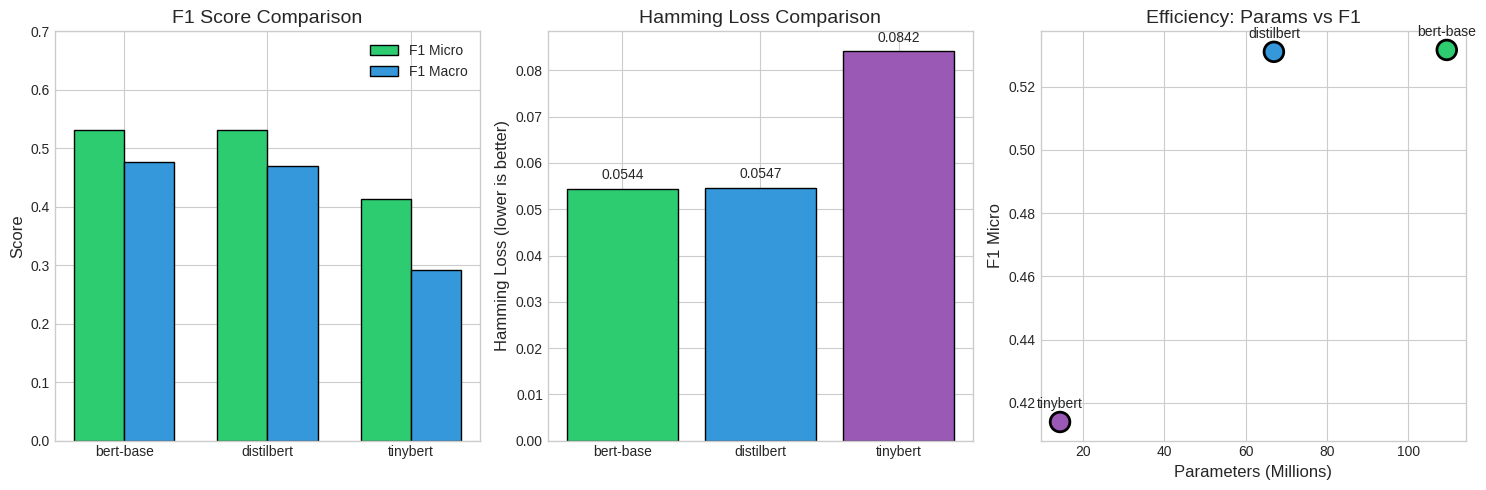

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = comparison_df['Model'].tolist()
colors = ['#2ecc71', '#3498db', '#9b59b6']

x = np.arange(len(models))
width = 0.35
axes[0].bar(x - width/2, comparison_df['F1 Micro'], width, label='F1 Micro', color=colors[0], edgecolor='black')
axes[0].bar(x + width/2, comparison_df['F1 Macro'], width, label='F1 Macro', color=colors[1], edgecolor='black')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('F1 Score Comparison', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].set_ylim(0, 0.7)

bars = axes[1].bar(models, comparison_df['Hamming Loss'], color=colors, edgecolor='black')
axes[1].set_ylabel('Hamming Loss (lower is better)', fontsize=12)
axes[1].set_title('Hamming Loss Comparison', fontsize=14)
for bar, val in zip(bars, comparison_df['Hamming Loss']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                f'{val:.4f}', ha='center', fontsize=10)

axes[2].scatter(comparison_df['Parameters (M)'], comparison_df['F1 Micro'],
               s=200, c=colors, edgecolor='black', linewidth=2)
for i, model in enumerate(models):
    axes[2].annotate(model, 
                    (comparison_df['Parameters (M)'].iloc[i], comparison_df['F1 Micro'].iloc[i]),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)
axes[2].set_xlabel('Parameters (Millions)', fontsize=12)
axes[2].set_ylabel('F1 Micro', fontsize=12)
axes[2].set_title('Efficiency: Params vs F1', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(config.LOG_DIR, 'model_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()